# Experiments simulation 7


## Imports

In [1]:
import os, sys, random, pickle
from datetime import datetime
from zoneinfo import ZoneInfo  
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from PyDistances.mixed import FastGGowerDistMatrix
sns.set_style('whitegrid')

current_path = os.getcwd()
src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..', '..', 'config')
sys.path.append(src_path)
sys.path.append(config_path)

from simulations_utils import get_simulation_8

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names, 
                               split_list_in_chunks)

from config_experiment_1_simulation_8 import get_config as get_config_exp_1_sim_8
from config_experiment_3_simulation_8 import get_config as get_config_exp_3_sim_8
from config_experiment_4_simulation_8 import get_config as get_config_exp_4_sim_8


## Data Simulation

In [2]:
X, y, outliers_idx = get_simulation_8(random_state=123, return_outlier_idx=True)

In [3]:
# polars conversion for data exploration
X_pl = pl.from_pandas(X)

## Data Exploration

In [4]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,4.898125,-4.318488,-6.495660,3.293892,1,0,2,3
1,4.724179,-5.480368,-6.191131,-2.003430,1,0,2,2
2,-22.170999,-16.785897,-6.476798,2.053391,1,0,3,3
3,1.763960,-3.319433,-5.044555,6.200091,1,0,3,1
4,1.047141,0.329004,-3.999907,3.092541,1,0,2,0


In [5]:
X.shape

(300000, 8)

In [6]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.2, 1: 0.3, 2: 0.5}


In [7]:
# Outliers information
outliers_table(X_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""X1""",-18.881691,12.93484,14490,285510,0.0483,0.9517
"""X2""",-14.418439,4.521212,15060,284940,0.0502,0.9498
"""X3""",-11.957871,8.385049,825,299175,0.00275,0.99725
"""X4""",-6.73106,10.652259,1177,298823,0.003923,0.996077


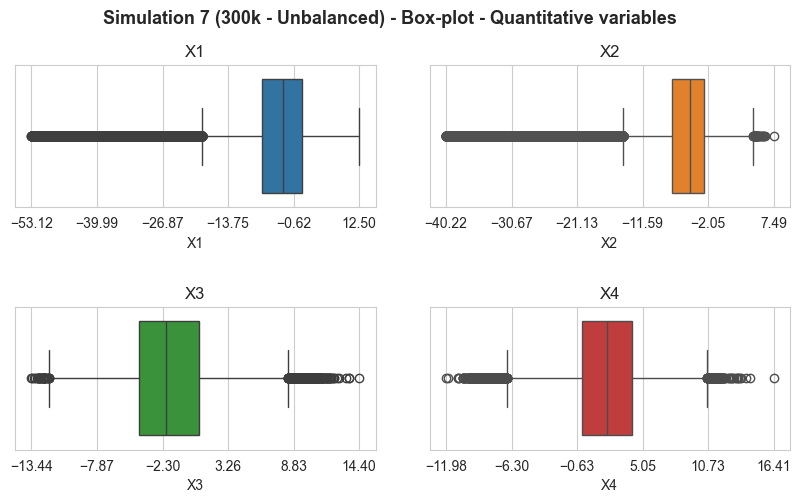

In [8]:
# Boxplot after outliers contamination
boxplot_matrix(X_pl, 
               n_cols=2, 
               title='Simulation 7 (300k - Unbalanced) - Box-plot - Quantitative variables', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

In [9]:
# Boxplot before outliers contamination
'''
boxplot_matrix(X_not_outliers, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)
'''

"\nboxplot_matrix(X_not_outliers, \n               n_cols=2, \n               title='Box-plot - Quantitative variables - Before outliers contamination', \n               figsize=(10,5), \n               quant_col_names=['X1', 'X2', 'X3', 'X4'], \n               n_xticks=6, \n               title_fontsize=13, \n               save=False, \n               file_name='', \n               x_rotation=0, \n               title_height=0.99,\n               style='whitegrid', \n               hspace=0.7, \n               wspace=0.15, \n               title_weight='bold',\n               subtitles_fontsize=12, \n               xlabel_size=10)\n"

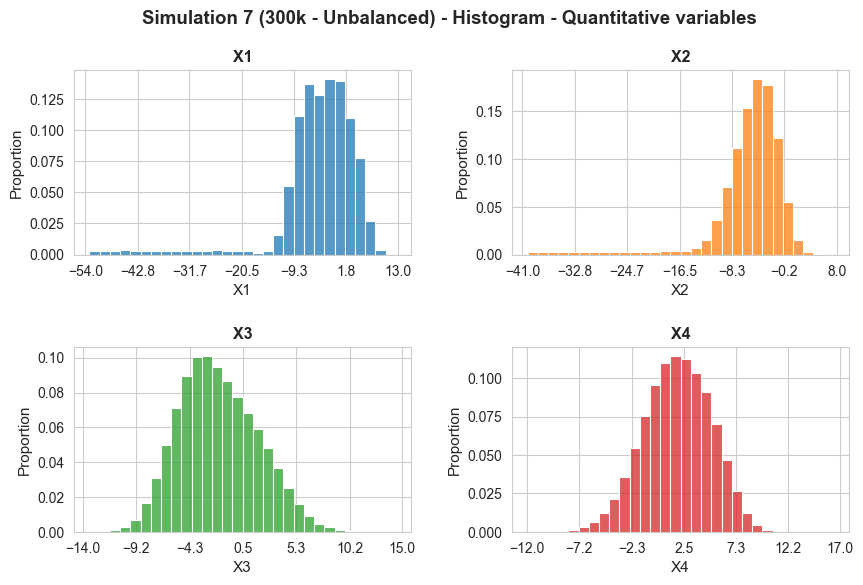

In [10]:
# Histogram
histogram_matrix(df=X_pl, bins=30, n_cols=2, 
                 title='Simulation 7 (300k - Unbalanced) - Histogram - Quantitative variables', 
                 figsize=(10,6), quant_col_names=['X1', 'X2', 'X3', 'X4'], 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

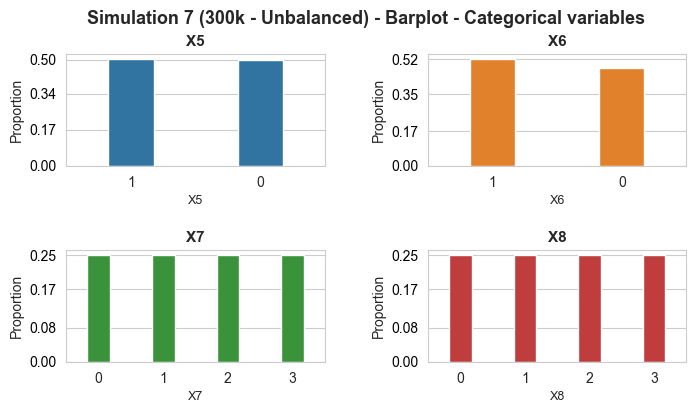

In [11]:
# Barplot
barplot_matrix(df=X_pl, n_cols=2, 
               title='Simulation 7 (300k - Unbalanced) - Barplot - Categorical variables', 
                 figsize=(8,4), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.75, wspace=0.4, title_weight='bold', bar_width=0.35,
                 ylabel_size=10, xlabel_size=9, xticks_size=10)

In [12]:
# Correlation Matrix
X[['X1', 'X2', 'X3', 'X4']].corr()

,X1,X2,X3,X4
X1,1.000000,0.822389,-0.310980,0.105819
X2,0.822389,1.000000,-0.158359,0.161084
X3,-0.310980,-0.158359,1.000000,-0.177499
X4,0.105819,0.161084,-0.177499,1.000000


In [13]:
# Correlation Analysis
corr_matrix = X[['X1', 'X2', 'X3', 'X4']].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.17
Proportion of pair-wise correlations in [0.30, 0.60]:  0.17
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.67


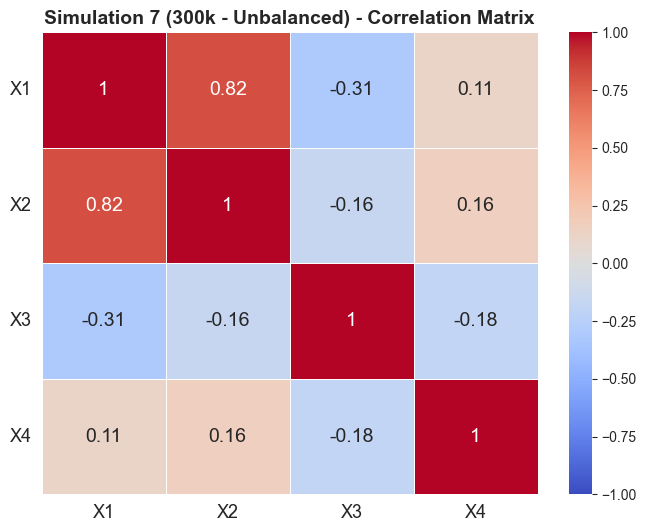

In [14]:
# Matriz de correlaciones
corr = X[['X1', 'X2', 'X3', 'X4']].corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(
    corr, 
    annot=True,                 # Muestra los valores dentro de las celdas
    cmap="coolwarm",            # Paleta de colores
    vmin=-1, vmax=1,             # Escala del colorbar
    linewidths=0.5,             # Líneas entre celdas
    annot_kws={"size": 14}      # Tamaño del texto dentro de las celdas
)

# Personalizar etiquetas
plt.xticks(fontsize=13)         # Tamaño etiquetas eje X
plt.yticks(fontsize=13, rotation=0)  # Tamaño etiquetas eje Y (sin rotación)
plt.title("Simulation 7 (300k - Unbalanced) - Correlation Matrix", fontsize=14, fontweight='bold')
plt.show()

## Experiment 1: Accuracy and computation time for Fast k-medoids (section 3.2)

In [29]:
run_experiment_1 = True

In [30]:
if run_experiment_1: 
        
    n_realizations = 70
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 2
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_7')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251009_181109'
    
    experiment_1_config = get_config_exp_1_sim_8()

    X, y = get_simulation_8(random_state=experiment_random_state, return_outlier_idx=False)


In [ ]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print("chunk_id:", chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**experiment_1_config,
                                                      X=X, 
                                                      y=y,
                                                      random_state=random_state,
                                                      metric=balanced_accuracy_score
                                                      )
            
        # Save results
        results_filename = f'results_exp_1_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization 
## IBiDat Server: 2335 mins

chunks:   0%|          | 0/35 [00:00<?, ?chunks/s]

chunk_id: 0
random_state_chunk: [6863, 35084]
random_state: 6863
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 35084
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:   3%|▎         | 1/35 [1:11:02<40:15:30, 4262.66s/chunks]

chunk_id: 1
random_state_chunk: [11427, 53377]
random_state: 11427
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 53377
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:   6%|▌         | 2/35 [2:18:04<37:46:30, 4120.93s/chunks]

chunk_id: 2
random_state_chunk: [34937, 14116]
random_state: 34937
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 14116
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:   9%|▊         | 3/35 [3:22:26<35:34:51, 4002.85s/chunks]

chunk_id: 3
random_state_chunk: [5000, 49692]
random_state: 5000
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 49692
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  11%|█▏        | 4/35 [4:34:40<35:35:33, 4133.35s/chunks]

chunk_id: 4
random_state_chunk: [43541, 44669]
random_state: 43541
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 44669
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  14%|█▍        | 5/35 [5:41:26<34:03:48, 4087.63s/chunks]

chunk_id: 5
random_state_chunk: [6802, 20927]
random_state: 6802
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 20927
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  17%|█▋        | 6/35 [6:53:25<33:33:43, 4166.31s/chunks]

chunk_id: 6
random_state_chunk: [17702, 44199]
random_state: 17702
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 44199
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  20%|██        | 7/35 [8:08:30<33:15:53, 4276.91s/chunks]

chunk_id: 7
random_state_chunk: [43751, 32134]
random_state: 43751
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 32134
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  23%|██▎       | 8/35 [9:19:50<32:05:00, 4277.81s/chunks]

chunk_id: 8
random_state_chunk: [21466, 218]
random_state: 21466
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 218
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  26%|██▌       | 9/35 [10:30:47<30:50:57, 4271.45s/chunks]

chunk_id: 9
random_state_chunk: [57183, 11483]
random_state: 57183
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 11483
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  29%|██▊       | 10/35 [11:39:26<29:20:08, 4224.35s/chunks]

chunk_id: 10
random_state_chunk: [49492, 9158]
random_state: 49492
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 9158
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  31%|███▏      | 11/35 [12:49:26<28:06:45, 4216.88s/chunks]

chunk_id: 11
random_state_chunk: [864, 41347]
random_state: 864
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 41347
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  34%|███▍      | 12/35 [14:03:34<27:23:27, 4287.27s/chunks]

chunk_id: 12
random_state_chunk: [58762, 13374]
random_state: 58762
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 13374
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  37%|███▋      | 13/35 [15:08:11<25:26:27, 4163.05s/chunks]

chunk_id: 13
random_state_chunk: [5752, 12158]
random_state: 5752
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 12158
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  40%|████      | 14/35 [16:15:51<24:06:05, 4131.69s/chunks]

chunk_id: 14
random_state_chunk: [18635, 16547]
random_state: 18635
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 16547
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  43%|████▎     | 15/35 [17:23:36<22:50:32, 4111.65s/chunks]

chunk_id: 15
random_state_chunk: [2783, 38247]
random_state: 2783
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 38247
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  46%|████▌     | 16/35 [18:33:20<21:48:57, 4133.57s/chunks]

chunk_id: 16
random_state_chunk: [56444, 62511]
random_state: 56444
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 62511
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  49%|████▊     | 17/35 [19:37:09<20:12:35, 4041.96s/chunks]

chunk_id: 17
random_state_chunk: [34776, 61511]
random_state: 34776
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 61511
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  51%|█████▏    | 18/35 [20:44:16<19:03:57, 4037.51s/chunks]

chunk_id: 18
random_state_chunk: [4816, 39989]
random_state: 4816
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 39989
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  54%|█████▍    | 19/35 [21:44:04<17:20:36, 3902.27s/chunks]

chunk_id: 19
random_state_chunk: [45018, 68376]
random_state: 45018
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 68376
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  57%|█████▋    | 20/35 [22:41:05<15:39:30, 3758.02s/chunks]

chunk_id: 20
random_state_chunk: [63302, 27113]
random_state: 63302
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 27113
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  60%|██████    | 21/35 [23:42:12<14:30:30, 3730.73s/chunks]

chunk_id: 21
random_state_chunk: [69084, 41322]
random_state: 69084
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 41322
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  63%|██████▎   | 22/35 [24:46:24<13:36:11, 3767.01s/chunks]

chunk_id: 22
random_state_chunk: [1644, 52197]
random_state: 1644
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 52197
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  66%|██████▌   | 23/35 [25:52:51<12:46:34, 3832.88s/chunks]

chunk_id: 23
random_state_chunk: [67207, 56935]
random_state: 67207
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 56935
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  69%|██████▊   | 24/35 [27:00:03<11:53:40, 3892.81s/chunks]

chunk_id: 24
random_state_chunk: [63718, 68237]
random_state: 63718
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 68237
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  71%|███████▏  | 25/35 [28:05:25<10:50:14, 3901.48s/chunks]

chunk_id: 25
random_state_chunk: [54984, 49089]
random_state: 54984
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 49089
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  74%|███████▍  | 26/35 [29:06:50<9:35:27, 3836.42s/chunks] 

chunk_id: 26
random_state_chunk: [66855, 4173]
random_state: 66855
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 4173
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  77%|███████▋  | 27/35 [30:15:43<8:43:25, 3925.68s/chunks]

chunk_id: 27
random_state_chunk: [23784, 10827]
random_state: 23784
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 10827
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  80%|████████  | 28/35 [31:18:44<7:32:55, 3882.21s/chunks]

chunk_id: 28
random_state_chunk: [63819, 34326]
random_state: 63819
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 34326
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  83%|████████▎ | 29/35 [32:21:44<6:25:08, 3851.37s/chunks]

chunk_id: 29
random_state_chunk: [22298, 43896]
random_state: 22298
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 43896
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  86%|████████▌ | 30/35 [33:30:42<5:28:07, 3937.59s/chunks]

chunk_id: 30
random_state_chunk: [44160, 51274]
random_state: 44160
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 51274
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  89%|████████▊ | 31/35 [34:34:11<4:19:55, 3898.76s/chunks]

chunk_id: 31
random_state_chunk: [9606, 59869]
random_state: 9606
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 59869
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  91%|█████████▏| 32/35 [35:38:18<3:14:10, 3883.49s/chunks]

chunk_id: 32
random_state_chunk: [50810, 44054]
random_state: 50810
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 44054
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  94%|█████████▍| 33/35 [36:42:02<2:08:51, 3865.53s/chunks]

chunk_id: 33
random_state_chunk: [2137, 24780]
random_state: 2137
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 24780
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks:  97%|█████████▋| 34/35 [37:53:21<1:06:29, 3989.68s/chunks]

chunk_id: 34
random_state_chunk: [11554, 47646]
random_state: 11554
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
random_state: 47646
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3


chunks: 100%|██████████| 35/35 [38:55:44<00:00, 4004.13s/chunks]  


In [32]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_chunk = {}
    file_id = '20251009_181109'
    results_folder_path = os.path.join(current_path, '..', '..',  'results', 'results_experiment_1', 'simulation_7')
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [16]:
# Open merged/joined results 
file_id = '20251009_181109'
results_filename = f'results_exp_1_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_7')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [17]:
experiment_1_config = get_config_exp_1_sim_8()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [18]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

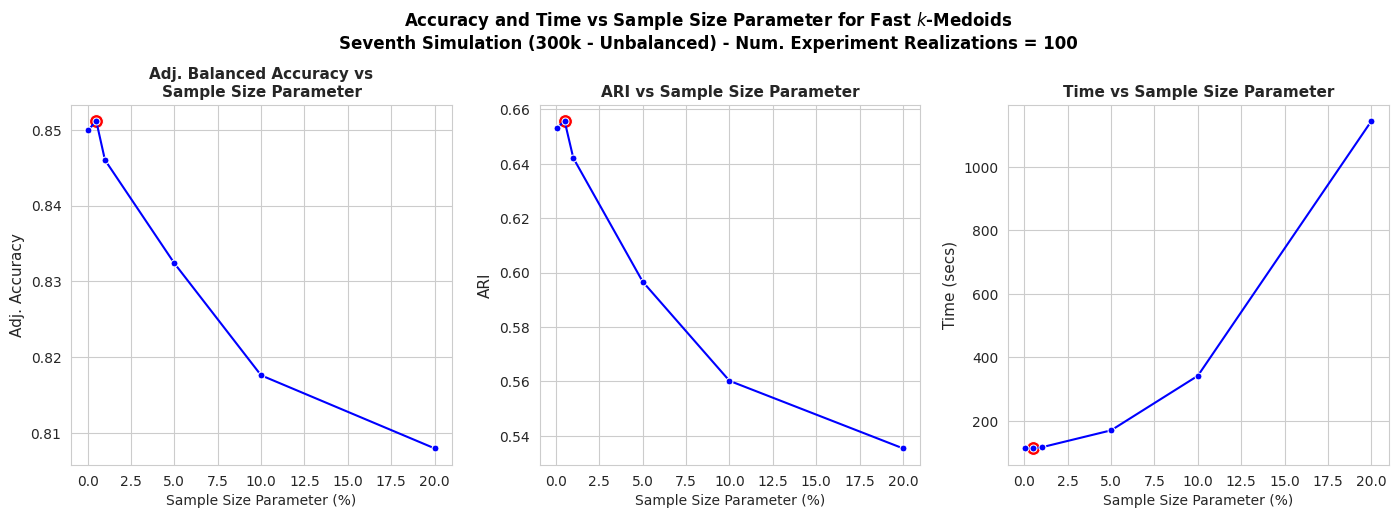

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Balanced Accuracy vs\nSample Size Parameter', size=11, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs Sample Size Parameter', size=11, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs Sample Size Parameter', size=11, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=10)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy and Time vs Sample Size Parameter for Fast $k$-Medoids\nSeventh Simulation (300k - Unbalanced) - Num. Experiment Realizations = 100', fontsize=12, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_simu_7_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [37]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.0005,113.333672,0.850022,0.653131
0.0050,113.460323,0.851165,0.655726
0.0100,116.735979,0.846029,0.642147
0.0500,170.082221,0.832384,0.596672
0.1000,341.927794,0.817584,0.560211
0.2000,1144.275379,0.807939,0.535379


In [38]:
print(best_frac_sample_size)

0.005



## Experiment 3: Accuracy, computation time and number of folds for q-Fold Fast k-medoids 

In [4]:
run_experiment_3 = True

In [ ]:
if run_experiment_3: 

    n_realizations = 70
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 2
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_7')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251009_181109'

    experiment_3_config = get_config_exp_3_sim_8()

    X, y = get_simulation_8(random_state=experiment_random_state, return_outlier_idx=False)

In [6]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**experiment_3_config,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization
## IBiDat server: 3000 mins 

  0%|          | 0/6 [00:00<?, ?it/s]

random_state_chunk: [22298, 43896]
random_state: 22298
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.46s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.57s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.19s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.01s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.63s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 43896
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.70s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.01s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


 17%|█▋        | 1/6 [54:59<4:34:58, 3299.71s/it]

random_state_chunk: [44160, 51274]
random_state: 44160
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:34<00:00, 18.97s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.13s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.90s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 51274
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.07s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:39<00:00, 31.86s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.01s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.77s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.63s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.41s/it]


frac_sample_size: 0.15


 33%|███▎      | 2/6 [1:49:53<3:39:44, 3296.18s/it]

random_state_chunk: [9606, 59869]
random_state: 9606
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:34<00:00, 18.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.85s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.69s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:39<00:00, 10.00s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.72s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.63s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 59869
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.09s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.03s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:54<00:00, 22.88s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.66s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.84s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


 50%|█████     | 3/6 [2:44:48<2:44:46, 3295.63s/it]

random_state_chunk: [50810, 44054]
random_state: 50810
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:46<00:00, 33.24s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.21s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.45s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 44054
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.21s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.60s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.88s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.41s/it]


frac_sample_size: 0.15


 67%|██████▋   | 4/6 [3:39:56<1:50:01, 3300.58s/it]

random_state_chunk: [2137, 24780]
random_state: 2137
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 24.00s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.72s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.20s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:39<00:00,  9.99s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.66s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 24780
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.08s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.18s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.35s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.09s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.69s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


 83%|████████▎ | 5/6 [4:34:54<54:59, 3299.61s/it]  

random_state_chunk: [11554, 47646]
random_state: 11554
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.31s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.02s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.19s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.01s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.67s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.63s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.01s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 47646
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.09s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.83s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.59s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.16s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:39<00:00,  9.99s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.67s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


100%|██████████| 6/6 [5:29:40<00:00, 3296.67s/it]


In [ ]:
if run_experiment_3: 

    # Open results by chunk
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_7')
    chunk_ids = range(len(os.listdir(results_folder_path)))
    file_id = '20251009_181109'    
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [6]:
# Open merged/joined results 
file_id = '20251009_181109'
results_filename = f'results_exp_3_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_7')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [7]:
experiment_3_config = get_config_exp_3_sim_8()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

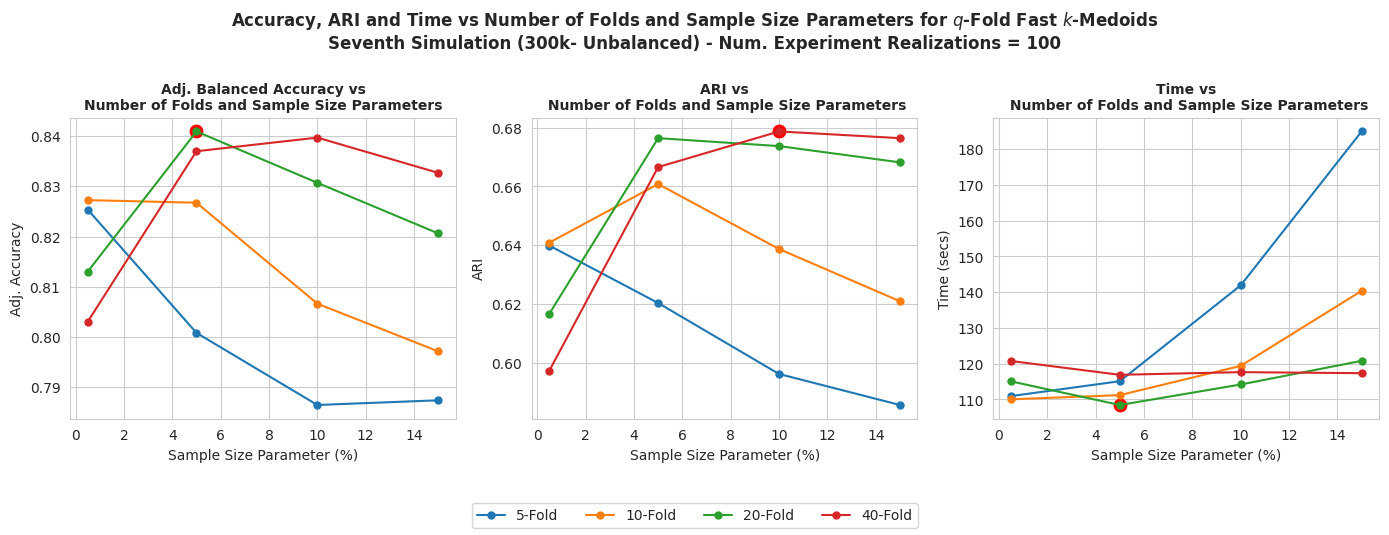

In [25]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(14, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Balanced Accuracy vs\nNumber of Folds and Sample Size Parameters", fontsize=10, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size = 10)
ax1.set_ylabel("Adj. Accuracy", size = 10)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of Folds and Sample Size Parameters", fontsize=10, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size = 10)
ax2.set_ylabel("ARI", size = 10)

# Tercer subplot: Time
ax3 = axes[2]
ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of Folds and Sample Size Parameters", fontsize=10, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size = 10)
ax3.set_ylabel("Time (secs)", size = 10)

# Título general
fig.suptitle("Accuracy, ARI and Time vs Number of Folds and Sample Size Parameters for $q$-Fold Fast $k$-Medoids\nSeventh Simulation (300k- Unbalanced) - Num. Experiment Realizations = 100", fontsize=12, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_simu_7_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


In [13]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.005,0.825368,0.639880,110.949629
1,5,0.050,0.800836,0.620319,115.110482
2,5,0.100,0.786489,0.596163,141.929145
3,5,0.150,0.787421,0.585606,184.980797
4,10,0.005,0.827241,0.640901,110.051787
5,10,0.050,0.826731,0.660816,111.214517
6,10,0.100,0.806644,0.638704,119.401457
7,10,0.150,0.797150,0.620924,140.387637
8,20,0.005,0.813007,0.616679,115.067392
9,20,0.050,0.840904,0.676450,108.459751


In [14]:
best_frac_sample_size = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['frac_sample_sizes']
best_n_splits = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['n_splits']
n = len(X)
split_ratio = np.round((best_n_splits/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_n_splits, '\n', 'best_frac_sample_size', best_frac_sample_size)

 split_ratio 0.007 
 best_n_splits 20.0 
 best_frac_sample_size 0.05


## Experiment 4: Empirical comparison to other existing algorithms (section 3.5)

In [3]:
run_experiment_4 = True

In [4]:
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans
from clustpy.hierarchical import Diana

experiment_4_config = get_config_exp_4_sim_8()

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

models = {
    
    'KMeans': KMeans(
        n_clusters=experiment_4_config['n_clusters'], 
        random_state=experiment_4_config['random_state'], 
        init='k-means++', 
        n_init='auto', 
        max_iter=experiment_4_config['max_iter']),

    'CLARA': CLARA(n_clusters=experiment_4_config['n_clusters'], 
                   metric='euclidean'),

    'LDAKmeans': LDAKmeans(n_clusters=experiment_4_config['n_clusters']),

    'SubKmeans': SubKmeans(n_clusters=experiment_4_config['n_clusters']),

    'GaussianMixture': GaussianMixture(n_components=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state']),

    'SpectralBiclustering': SpectralBiclustering(n_clusters=experiment_4_config['n_clusters']),

    'SpectralCoclustering': SpectralCoclustering(n_clusters=experiment_4_config['n_clusters']),

    'BisectingKMeans': BisectingKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter']),

    'MiniBatchKMeans': MiniBatchKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter'])
                                       
}

#################################################################################################

for d in GGower_distances_names:

    d1, d2, d3 = d.split('-')

    if 'robust' in d1:
        r = d1.split('_')[-1]
        d1 = '_'.join(d1.split('_')[:2])
        
    models[f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size_fast_kmedoids'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples']) 

    models[f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size_fold_fast_kmedoids'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples'],
            n_splits=experiment_4_config['n_splits'], 
            shuffle=experiment_4_config['shuffle'], 
            kfold_random_state=experiment_4_config['kfold_random_state']) 

In [7]:
if run_experiment_4: 
   
    n_realizations = 70
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 2
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_7')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251010_131308'

In [ ]:
if run_experiment_4: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        

            X, y = get_simulation_8(
                random_state=random_state, 
                return_outlier_idx=False)
            
            results[random_state] = make_experiment_4(
                X=X, 
                y=y, 
                models=models,
                metric=balanced_accuracy_score
            )

        # Save results
        results_filename = f'results_exp_4_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realizations: 
## IBiDat server compute: 1700 mins  

chunks:   0%|          | 0/7 [00:00<?, ?chunks/s]

chunk_id 28
random_state_chunk: [63819, 34326]
random_state: 63819
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:31<00:00,  4.59s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.70s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


len y_pred: 3
random_state: 34326
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:31<00:00,  4.59s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


len y_pred: 3


chunks:  14%|█▍        | 1/7 [40:12<4:01:16, 2412.74s/chunks]

chunk_id 29
random_state_chunk: [22298, 43896]
random_state: 22298
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


len y_pred: 3
random_state: 43896
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


len y_pred: 3


chunks:  29%|██▊       | 2/7 [1:20:15<3:20:33, 2406.66s/chunks]

chunk_id 30
random_state_chunk: [44160, 51274]
random_state: 44160
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:31<00:00,  4.59s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


len y_pred: 3
random_state: 51274
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


len y_pred: 3


chunks:  43%|████▎     | 3/7 [2:00:07<2:40:00, 2400.15s/chunks]

chunk_id 31
random_state_chunk: [9606, 59869]
random_state: 9606
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:31<00:00,  4.60s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.80s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:56<00:00,  5.82s/it]


len y_pred: 3
random_state: 59869
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:48<00:00,  5.43s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:45<00:00,  5.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:57<00:00,  5.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [02:02<00:00,  6.10s/it]


len y_pred: 3


chunks:  57%|█████▋    | 4/7 [2:44:48<2:05:32, 2510.88s/chunks]

chunk_id 32
random_state_chunk: [50810, 44054]
random_state: 50810
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:46<00:00,  5.33s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:46<00:00,  5.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:50<00:00,  5.53s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  6.00s/it]


len y_pred: 3
random_state: 44054
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:49<00:00,  5.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:46<00:00,  5.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:56<00:00,  5.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.01s/it]


len y_pred: 3


chunks:  71%|███████▏  | 5/7 [3:30:27<1:26:26, 2593.09s/chunks]

chunk_id 33
random_state_chunk: [2137, 24780]
random_state: 2137
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:44<00:00,  5.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:51<00:00,  5.59s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:49<00:00,  5.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [02:02<00:00,  6.14s/it]


len y_pred: 3
random_state: 24780
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:44<00:00,  5.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:39<00:00,  4.99s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:54<00:00,  5.73s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:52<00:00,  5.64s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:57<00:00,  5.89s/it]


len y_pred: 3


chunks:  86%|████████▌ | 6/7 [4:15:49<43:56, 2636.92s/chunks]  

chunk_id 34
random_state_chunk: [11554, 47646]
random_state: 11554
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:50<00:00,  5.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:50<00:00,  5.55s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:48<00:00,  5.41s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:57<00:00,  5.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [02:02<00:00,  6.10s/it]


len y_pred: 3
random_state: 47646
KMeans
len y_pred: 3
CLARA
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:49<00:00,  5.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:50<00:00,  5.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 20/20 [01:51<00:00,  5.56s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.80s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


len y_pred: 3


chunks: 100%|██████████| 7/7 [5:02:17<00:00, 2591.03s/chunks]


In [8]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_7')
    file_id = '20251010_131308'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [9]:
# Open merged/joined results 
file_id = '20251010_131308'
results_filename = f'results_exp_4_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_7')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [10]:
model_names = list(models.keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [11]:
avg_results['std_adj_acc'] = {k: np.std(pivoted_results['adj_accuracy'][k]) for k in model_names}
avg_results['std_ARI'] = {k: np.std(pivoted_results['ARI'][k]) for k in model_names}
avg_results['std_time'] = {k: np.std(pivoted_results['time'][k]) for k in model_names}

In [12]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering', 'KMedoids-euclidean', 'Diana', 'AgglomerativeClustering', 'Birch'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0
    avg_results['std_adj_acc'][model_name] = 0
    avg_results['std_ARI'][model_name] = 0
    avg_results['std_time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
std_adj_acc = np.array(list(avg_results['std_adj_acc'].values()))
std_ari = np.array(list(avg_results['std_ARI'].values()))
std_time = np.array(list(avg_results['std_time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

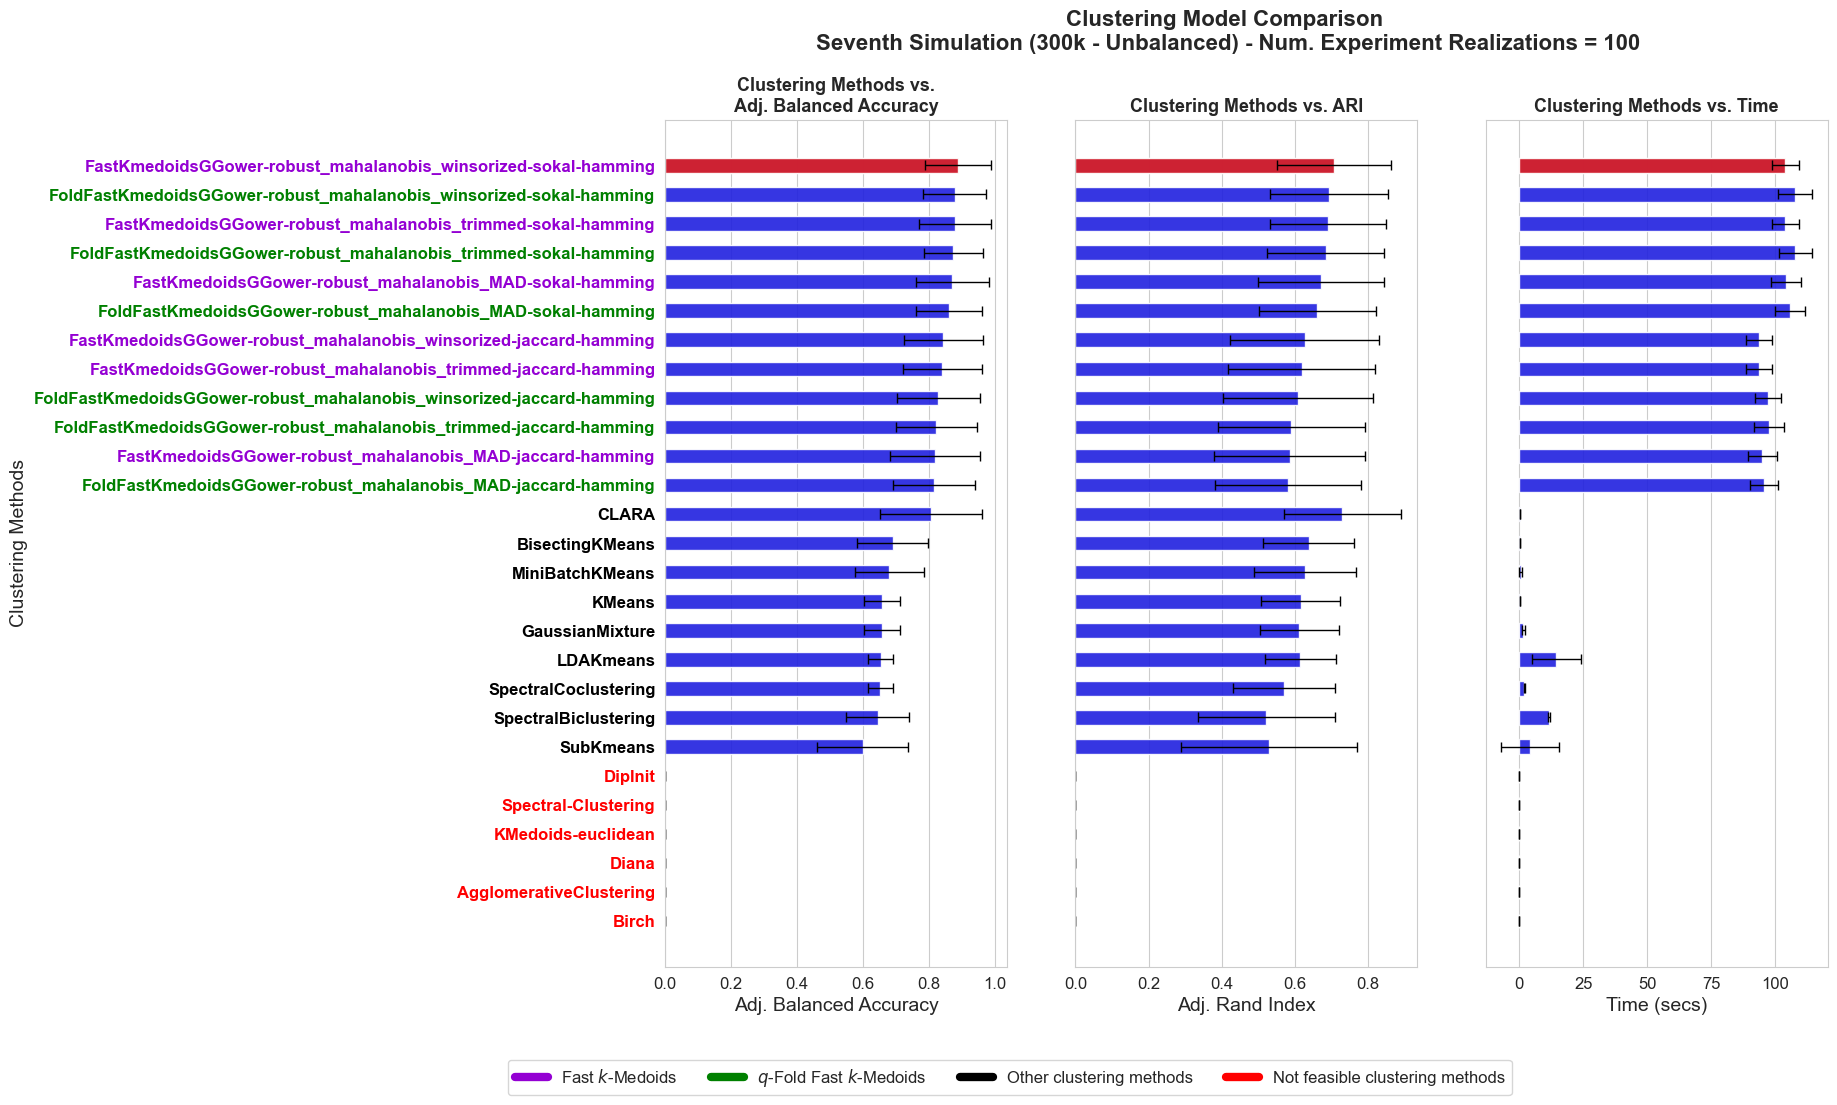

In [28]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

# Añadir barras de error manualmente
axes[0].errorbar(
    x=avg_adj_accuracy[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_adj_acc[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[1].errorbar(
    x=avg_ari[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_ari[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[2].errorbar(
    x=avg_time[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_time[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Balanced Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs.\nAdj. Balanced Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison \nSeventh Simulation (300k - Unbalanced) - Num. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.98)

plot_filename = f'plot_results_exp_4_simu_7_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [14]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [19]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI,std_adj_acc,std_ARI,std_time
models,,,,,,
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,103.898071,0.888032,0.706980,0.100095,0.156594,5.212375
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,107.773907,0.879282,0.694720,0.095329,0.160876,6.533995
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,103.936398,0.878990,0.692080,0.109241,0.158751,5.133699
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,107.846308,0.874645,0.684696,0.089200,0.160470,6.529495
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,104.249879,0.871424,0.672972,0.110252,0.172046,5.906474
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,105.728864,0.861712,0.662149,0.101074,0.160328,5.957011
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,93.579571,0.844162,0.627022,0.120817,0.203916,4.948807
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,93.661570,0.840995,0.619642,0.120530,0.200751,5.202707
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,97.157113,0.829250,0.608603,0.125671,0.204963,5.255506


In [20]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI,std_adj_acc,std_ARI,std_time
models,,,,,,
CLARA,0.308364,0.806717,0.730792,0.154121,0.160543,0.049289
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,103.898071,0.888032,0.706980,0.100095,0.156594,5.212375
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,107.773907,0.879282,0.694720,0.095329,0.160876,6.533995
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,103.936398,0.878990,0.692080,0.109241,0.158751,5.133699
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,107.846308,0.874645,0.684696,0.089200,0.160470,6.529495
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,104.249879,0.871424,0.672972,0.110252,0.172046,5.906474
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,105.728864,0.861712,0.662149,0.101074,0.160328,5.957011
BisectingKMeans,0.166256,0.691337,0.637998,0.107817,0.124255,0.063661
MiniBatchKMeans,0.489952,0.680593,0.627867,0.104920,0.138948,0.492362


### MDS vidualization

In [21]:
random_state_mds = 11554 

X, y, outliers_idx = get_simulation_8(random_state=random_state_mds, return_outlier_idx=True)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=100) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.005, 
                              random_state=experiment_4_config['random_state'], 
                              p1=experiment_4_config['p1'], 
                              p2=experiment_4_config['p2'], 
                              p3=experiment_4_config['p3'], 
                              d1='robust_mahalanobis', 
                              d2='sokal', 
                              d3='hamming', 
                              robust_method='winsorized', 
                              alpha=experiment_4_config['alpha'])

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

# Time: 52 secs

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [22]:
outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


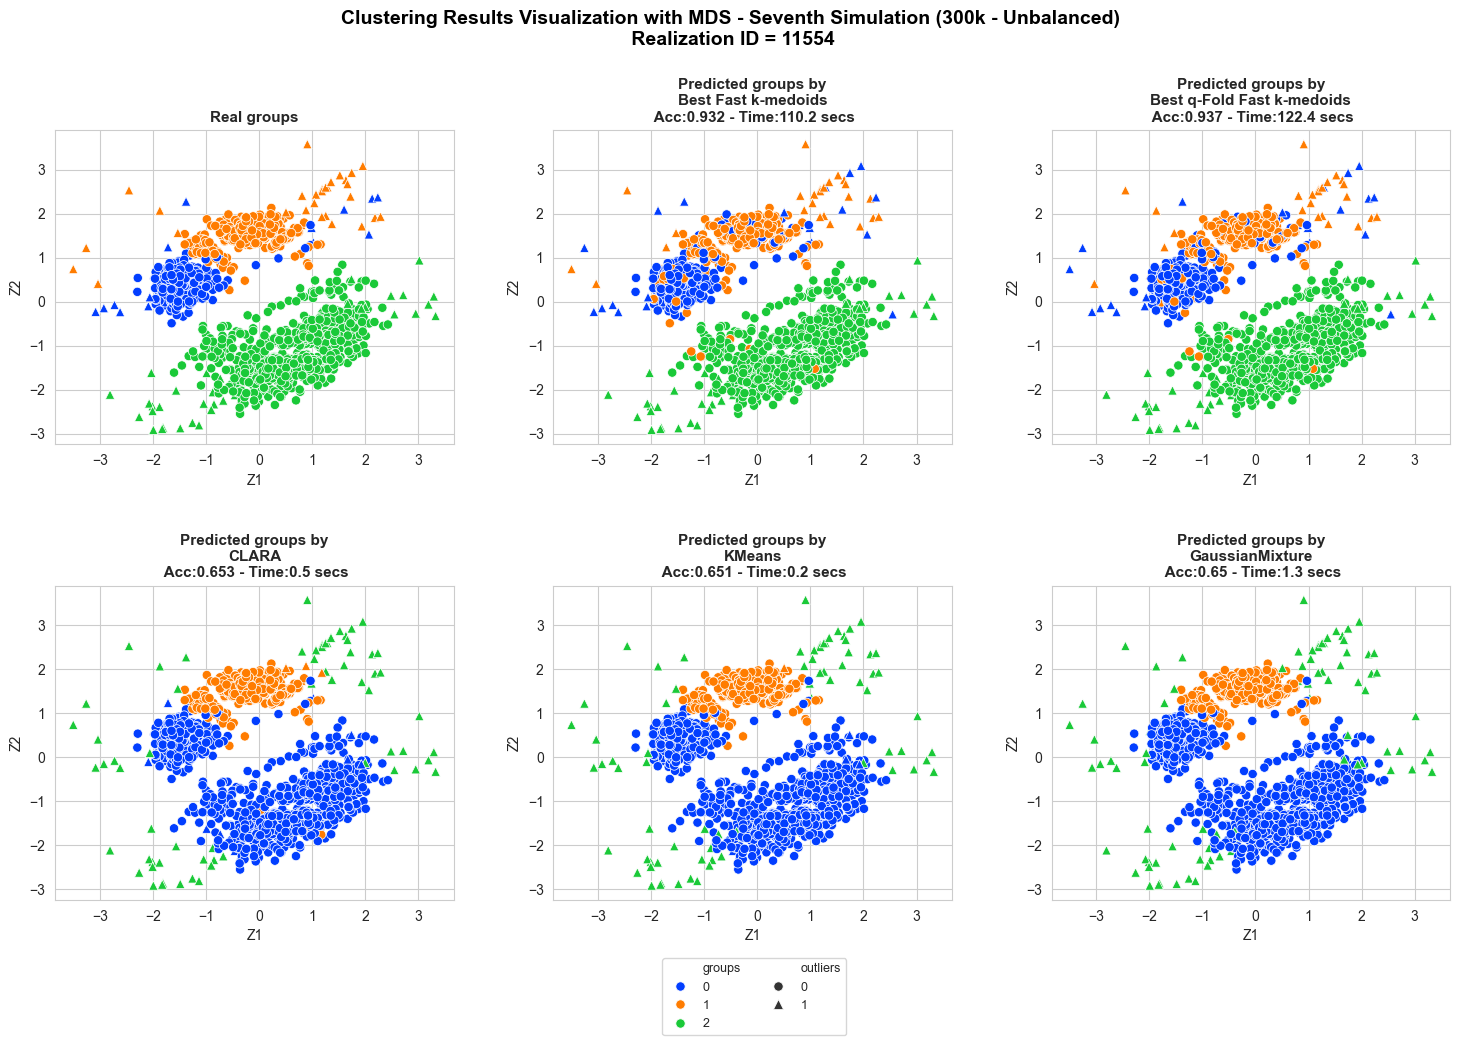

In [27]:
plot_filename = f'mds_plot_exp_4_simu_7_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_7')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Seventh Simulation (300k - Unbalanced)\n Realization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='', legend_size=9, 
                                     save = True, file_name = plot_save_path
)